# Experimentation - Logistic Regression Model

## Summary

这个 Notebook 的目标读者是那些平时主要在单机本地 Jupyter Notebook 上开发 ML 模型的 Data Scientist. 介绍了如何在已有一个本地模型的情况下, 将其迁徙到 AWS Sagamaker, 从而利用 AWS 的高性能服务器来进行模型的训练部署. 我们假设你的 ML 模型在本地, 用很小的数据集已经跑通了, 但是你需要更大的服务器来用生产环境中的数据训练你的模型.

本例我们用的是 Kaggle 上 Titanic 灾难的数据集, 用 Sklearn 构建了一个简单的逻辑回归模型来预测船客是否能生存下来. 这个模型本身的性能不是我们关注的重点.

Reference:

- Python (Scikit-Learn): Logistic Regression Classification: https://towardsdatascience.com/python-scikit-learn-logistic-regression-classification-eb9c8de8938d
- Titanic - Machine Learning from Disaster: https://www.kaggle.com/c/titanic/data

## Build Model in Experimentation Environment

这一节我们来模拟在本地 Jupyter Notebook 上开发 ML 模型的过程. 我们的命名规则还是遵循 Sklearn 社区的规则:

- X_train: 二维矩阵, 训练数据, 没有 label
- X_test: 二维矩阵, 训练数据, 没有 label
- y_train: 一维数组, label 数据, 用于训练模型
- y_test: 一维数组, label 数据, 用于测试模型

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [57]:
# Read the data from CSV
df_train = pd.read_csv("./data/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Pre Processing

对数据进行预处理, 进行特征选择, 特征工程, 处理数据缺陷等问题.

In [58]:
def pre_processing(df: pd.DataFrame) -> pd.DataFrame:
    # 1. Drop features that do not seem to add any value to our model
    df = df.drop(
        ['PassengerId', 'Name', 'Ticket', 'Cabin'], 
        axis=1,
    )
    
    # 2. Create categorical dummies for the embarkment ports
    ports = pd.get_dummies(df.Embarked, prefix='Embarked')
    ports.head()
    
    df = df.join(ports)
    df = df.drop(['Embarked'], axis=1)

    # 3. Transform gender names to binaries
    df.Sex = df.Sex.map({'male': 0, 'female': 1})

    # 4. Replace missing values
    df[pd.isnull(df).any(axis=1)]
    
    df.Age = df.Age.fillna(df.Age.mean())
    return df
    
df_train_processed = pre_processing(df_train)
df_train_processed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


### Train and Test split

将处理好的数据分为测试和训练数据集.

In [69]:
y = df_train_processed.Survived.copy()
X = df_train_processed.drop(['Survived'], axis=1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=123,
)

In [71]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
660,1,0,50.0,2,0,133.6500,0,0,1
852,3,1,9.0,1,1,15.2458,1,0,0
703,3,0,25.0,0,0,7.7417,0,1,0
886,2,0,27.0,0,0,13.0000,0,0,1
525,3,0,40.5,0,0,7.7500,0,1,0


In [72]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
172,3,1,1.000000,1,1,11.1333,0,0,1
524,3,0,29.699118,0,0,7.2292,1,0,0
452,1,0,30.000000,0,0,27.7500,1,0,0
170,1,0,61.000000,0,0,33.5000,0,0,1
620,3,0,27.000000,1,0,14.4542,1,0,0


In [73]:
y_train.head()

660    1
852    0
703    0
886    0
525    0
Name: Survived, dtype: int64

In [74]:
y_test.head()

172    1
524    0
452    0
170    0
620    0
Name: Survived, dtype: int64

### A Simple Logistic Regression Model

In [75]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Use the Model to predict

使用训练好的模型进行预测, 并计算正确率.

In [77]:
y_pred = pd.Series(model.predict(X_test))
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()

,True,Prediction
0,1,1
1,0,0
2,0,1
3,0,0
4,0,0


In [78]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8071748878923767
Precision: 0.7469879518072289
Recall: 0.7380952380952381


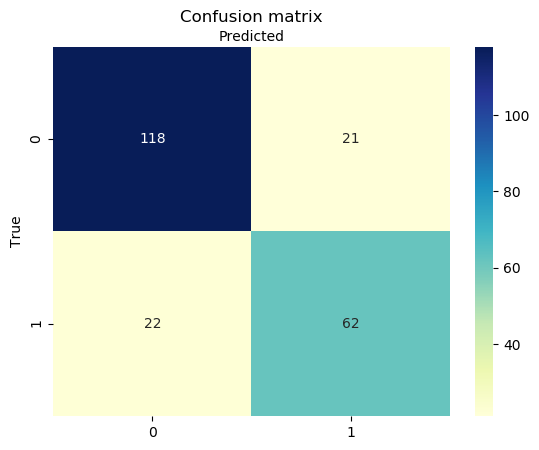

In [79]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

至此, 我们在本地的 Jupyter Notebook 上搭建了一个非常简单的逻辑回归二元分类模型. 在生产环境中我们希望能在更大的数据集上训练, 并且自动化模型的的训练, 测试, 部署流程. 在下一节我们重点介绍如何将已有的工作迁徙到 Sagemaker 中.

## Use Script Mode in SageMaker

Sagemaker Built-in Algorithm 是由 AWS 维护的各种常用 ML 框架, 算法的运行环境, 并且对其高度封装, 是的 Data Scientist 只需要用很少的代码就能创建一个 ML 模型. SkLearn 是 Sagemaker 所支持的框架之一.

对于 Built-in Algorithm, 有两种常用的在远程服务器上训练模型的方式:

1. Container mode algorithms offered through Estimators & Amazon Estimators. 这是经过高度封装的模型, 你只需要指定训练数据集, 需要的 EC2, 模型的参数, 它就能自动帮你启动 EC2 进行训练.
2. Script mode algorithms based on pre-built SageMaker Docker Images offered through Estimators. 这是针对那些没有被高度封装, 但是各个框架中又支持的算法. AWS 精力有限, 不可能把市场上所有的框架所有的算法都做一个封装. 该方法的原理是你自己按照一定的方式对模型进行封装, 本质上就是把你在本地调用那些框架的代码封装到一个函数里, 然后用一个 Python script 封装这个函数, 然后将 script 在对应框架的 Docker Image 中训练. 

我们这个例子中 LogisticRegression 无法使用 #1 的方式, 只能用 Script Mode.

参考资料:

- Bring in your own Model with Script Mode Tutorial: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-script-mode/sagemaker-script-mode.html
- Sample Train Script: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-script-mode/scikitlearn_script/train_deploy_scikitlearn_without_dependencies.py

In [82]:
# install dependencies in quiet mode (don't print too much log!)
%pip install s3pathlib -q
%pip install rich -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import os
from pathlib import Path
from s3pathlib import S3Path

dir_here = Path(os.getcwd())
dir_data = dir_here / "data"

# define the root s3 dir you use for this demo
s3dir = S3Path.from_s3_uri("s3://sagemaker-us-east-1-279139072714/demo/logistic-regression-example/")

# below are derived variables
s3path_train_csv = s3dir / "data" / "train.csv"
s3path_train_csv.upload_file(str(dir_data / "train.csv"), overwrite=True)
print(f"preview 'train.csv' at: {s3path_train_csv.console_url}")

preview 'train.csv' at: https://console.aws.amazon.com/s3/object/sagemaker-us-east-1-279139072714?prefix=demo/logistic-regression-example/data/train.csv


### Develop the Training Script

现在我们需要将 Experimentation Jupyter Notebook 中的代码转化成 Training Script

In [98]:
# standard library
import typing as T
import os
import re
import sys
import json
import traceback
import argparse
import dataclasses
from pathlib import Path

# 3rd party library
import boto3
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

s3_client = boto3.client("s3")


# this training script will be used in a docker image
# you could provide a simple command line interface to allow you pass in
# parameters, then you can pass parameter from your pipeline code

# another work around is to implement some logic to read parameter
# from metadata store like AWS Parameter Store / S3 / Dynamodb
# inside of this training script, then you could update the metadata store
# before training
def parse_args():
    """
    Parse arguments.
    """
    parser = argparse.ArgumentParser()

    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument(
        "--model_dir",
        type=str,
        default=os.environ.get("SM_MODEL_DIR"),
    )

    return parser.parse_known_args()


def load_df_titanic(bucket: str, key: str) -> pd.DataFrame:
    """
    Load training data set.
    """
    res = s3_client.get_object(
        Bucket=bucket,
        Key=key,
    )
    df = pd.read_csv(res["Body"])
    return df


def pre_processing(df: pd.DataFrame) -> pd.DataFrame:
    # 1. Drop features that do not seem to add any value to our model
    df = df.drop(
        ['PassengerId', 'Name', 'Ticket', 'Cabin'],
        axis=1,
    )

    # 2. Create categorical dummies for the embarkment ports
    ports = pd.get_dummies(df.Embarked, prefix='Embarked')
    ports.head()

    df = df.join(ports)
    df = df.drop(['Embarked'], axis=1)

    # 3. Transform gender names to binaries
    df.Sex = df.Sex.map({'male': 0, 'female': 1})

    # 4. Replace missing values
    df[pd.isnull(df).any(axis=1)]

    df.Age = df.Age.fillna(df.Age.mean())
    return df


def train_model():
    print("Training model")
    print("Load data")
    df_train = load_df_titanic(
        bucket="sagemaker-us-east-1-279139072714",
        key="demo/logistic-regression-example/data/train.csv",
    )
    df_train_processed = pre_processing(df_train)
    y = df_train_processed.Survived.copy()
    X = df_train_processed.drop(['Survived'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=123,
    )

    print("Training the classifier")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    print("Score: {}".format(model.score(X_test, y_test)))
    return model


def main(args):
    """
    Train a Logistic Regression Model
    """
    try:
        model = train_model(args)
        joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))
    except Exception as e:
        # Write out an error file. This will be returned as the failureReason in the
        # DescribeTrainingJob result.
        trc = traceback.format_exc()
        with Path(os.getcwd(), "failure.log").open("w") as f:
            f.write("Exception during training: " + str(e) + "\\n" + trc)

        # Printing this causes the exception to be in the training job logs, as well.
        print("Exception during training: " + str(e) + "\\n" + trc, file=sys.stderr)

        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)


def model_fn(model_dir):
    """
    Deserialized and return fitted model
    Note that this should have the same name as the serialized model in the main method
    """
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


def test():
    """
    Run this simple unit test locally before running this in script mode.
    """
    model = train_model()
    print(model)


if __name__ == "__main__":
    # test()
    args, _ = parse_args()
    main(args)

Training model
Load data
Training the classifier
Score: 0.8071748878923767
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


### Use the Training Script

In [106]:
import os
import sys
import math
import random
import subprocess

import boto3
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import NumpyDeserializer

In [107]:
ses = sagemaker.Session()
bucket = ses.default_bucket()
role = sagemaker.get_execution_role()

print(f"bucket = {bucket}")
print(f"role = {role}")

bucket = sagemaker-us-east-1-279139072714
role = arn:aws:iam::279139072714:role/service-role/AmazonSageMaker-ExecutionRole-20220928T221109


In [110]:
estimator_parameters = {
    "entry_point": "train.py",
    "source_dir": "scikitlearn_script",
    "framework_version": "1.0-1",
    "py_version": "py3",
    "instance_type": "ml.c5.xlarge",
    "instance_count": 1,
    "role": role,
    "base_job_name": "logisticregression-model",
}

estimator = SKLearn(**estimator_parameters)
estimator.fit()

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.c5.xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [102]:
sklearn_endpoint_name = "logisticregression-endpoint"

existing_endpoints = ses.sagemaker_client.list_endpoints(
    NameContains=sklearn_endpoint_name, MaxResults=30
)["Endpoints"]

if not existing_endpoints:
    sklearn_predictor = estimator.deploy(
        initial_instance_count=1, 
        instance_type="ml.m5.xlarge", 
        endpoint_name=sklearn_endpoint_name,
    )
else:
    sklearn_predictor = Predictor(
        endpoint_name=sklearn_endpoint_name,
        sagemaker_session=ses,
        serializer=NumpySerializer(),
        deserializer=NumpyDeserializer(),
    )
sklearn_predictor

In [103]:
# Read the data from CSV
df_train = pd.read_csv("./data/train.csv")

df_train_processed = pre_processing(df_train)

y = df_train_processed.Survived.copy()
X = df_train_processed.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=123,
)

y_pred = pd.Series(sklearn_predictor.predict(X_test))
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()

,True,Prediction
0,1,1
1,0,0
2,0,1
3,0,0
4,0,0


In [104]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8071748878923767
Precision: 0.7469879518072289
Recall: 0.7380952380952381


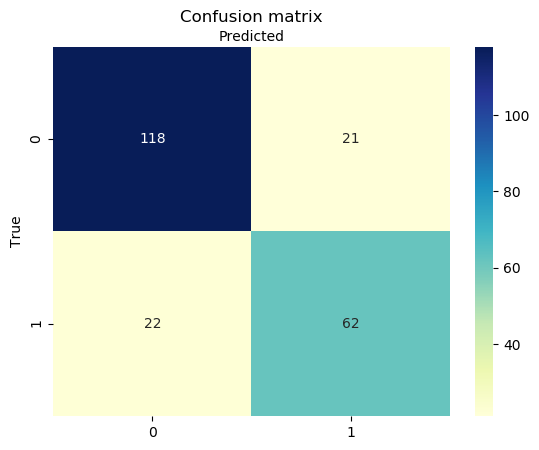

In [105]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()